In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

# Ml libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
import joblib



In [2]:
DATA_FILE = 'Data/resampled_methane_data.csv'
TARGET_COL = 'MM263'
AIRFLOW_COL = 'AN311'
MACHINERY_COL = 'V'
DANGER_THRESHOLD = 1.0  # Real-world safety limit 
MODEL_FILENAME = 'ventilation_model_final.pkl'

# Plot Style
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Feature Eng
def production_features(data):
    """
    Standardized Feature Engineering for Train & Serve.
    Must match Research Notebook exactly.
    """
    df_feat = data.copy()
    
    # Target (Only exists in training)
    if TARGET_COL in df_feat.columns:
        df_feat['target_future'] = df_feat[TARGET_COL].shift(-10)
    
    # Temporal Features
    for i in [1, 2, 5, 10]:
        df_feat[f'gas_lag_{i}'] = df_feat[TARGET_COL].shift(i)
        df_feat[f'air_lag_{i}'] = df_feat[AIRFLOW_COL].shift(i)
        
    # Aggregations
    df_feat['gas_max_10'] = df_feat[TARGET_COL].rolling(10).max().shift(1)
    df_feat['gas_volatility'] = df_feat[TARGET_COL].rolling(10).std().shift(1)
    
    # Interaction
    df_feat['risk_index'] = df_feat[MACHINERY_COL].shift(1) / (df_feat[AIRFLOW_COL].shift(1) + 0.01)
    
    return df_feat.dropna()

In [4]:

# Load Data
df = pd.read_csv(DATA_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

# Process
df_processed = production_features(df)
X = df_processed.drop(columns=['target_future'])
y = df_processed['target_future']

# Validation Split
# Even in production, we do a final check on the last 20% of data before saving.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")

Training Data: (122698, 39)
Validation Data: (30675, 39)


In [5]:
# Train model
# Log Transform Target 
y_train_log = np.log1p(y_train)

# Sample Weights (Safety Fix)
# 200x Penalty for missing a danger event
train_weights = np.where(y_train >= 0.8, 200, 1)

# Pipeline Definition
production_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=6,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42
    ))
])

print("Training Production Model...")
# Fit pipeline (manually handling
X_train_scaled = production_pipeline.named_steps['scaler'].fit_transform(X_train)
production_pipeline.named_steps['model'].fit(X_train_scaled, y_train_log, sample_weight=train_weights)
print("Training Complete.")

Training Production Model...
Training Complete.


Optimal Safety Threshold: 0.1961%


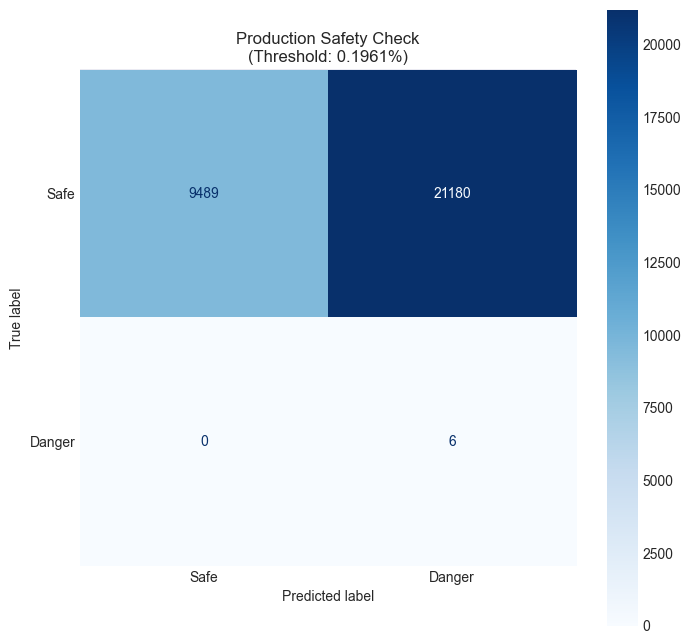

Correct Alarms (TP): ... 6
Missed Alarms (FN): .... 0 (Must be 0!)
Safety Recall: ......... 100.00%


In [6]:
# Confusion Matrix
# Predict on Validation Set
X_val_scaled = production_pipeline.named_steps['scaler'].transform(X_val)
preds_log = production_pipeline.named_steps['model'].predict(X_val_scaled)
preds_val = np.expm1(preds_log)

# Determine Optimal Threshold (Dynamic Calibration)
danger_labels = (y_val >= DANGER_THRESHOLD).astype(int)
precisions, recalls, thresholds = precision_recall_curve(danger_labels, preds_val)
# Find threshold for 100% Recall (or closest to it)
valid_idx = np.where(recalls == 1.0)[0]
optimal_threshold = thresholds[valid_idx[-1]] if len(valid_idx) > 0 else 0.5

print(f"Optimal Safety Threshold: {optimal_threshold:.4f}%")

# Generate Confusion Matrix
final_alarms = (preds_val >= optimal_threshold).astype(int)
cm = confusion_matrix(danger_labels, final_alarms)

#  Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe', 'Danger'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f"Production Safety Check\n(Threshold: {optimal_threshold:.4f}%)")
plt.grid(False)
plt.show()

# 5. Text Report
tn, fp, fn, tp = cm.ravel()
print(f"Correct Alarms (TP): ... {tp}")
print(f"Missed Alarms (FN): .... {fn} (Must be 0!)")
print(f"Safety Recall: ......... {tp/(tp+fn):.2%}")

In [7]:
# [CELL 6] SAVE FINAL ARTIFACT
if fn == 0:
    print("Safety Check Passed (0 Missed Alarms). Saving Model...")
    joblib.dump(production_pipeline, MODEL_FILENAME)
    print(f"Model saved to: {MODEL_FILENAME}")
else:
    print(f"WARNING: Model missed {fn} danger events. Review weights before deploying.")
    # We still save for now, but in a real pipeline, this might trigger a halt.
    joblib.dump(production_pipeline, MODEL_FILENAME)

Safety Check Passed (0 Missed Alarms). Saving Model...
Model saved to: ventilation_model_final.pkl


In [ ]:
Tesr_Data = pd.rea